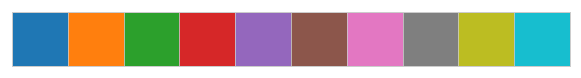

In [1]:
import numpy as np
import pandas as pd
import json
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import Ridge
from scipy.sparse import csr_matrix, hstack
from scipy.stats import probplot
import pickle
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
get_ipython().run_line_magic('matplotlib', 'inline')
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
import time
from html.parser import HTMLParser
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from nltk.stem import PorterStemmer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV, StratifiedKFold
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn import decomposition
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split

from sklearn.linear_model import Ridge

from sklearn.cluster import KMeans

color = sns.color_palette()
sns.set_style("whitegrid")
sns.set_context("paper")
sns.palplot(color)

import os
PATH = "../../data"

In [2]:
def read_json_line(line=None):
    result = None
    try:
        result = json.loads(line)
    except Exception as e:
        # Find the offending character index:
        idx_to_replace = int(str(e).split(' ')[-1].replace(')',''))
        # Remove the offending character:
        new_line = list(line)
        new_line[idx_to_replace] = ' '
        new_line = ''.join(new_line)
        return read_json_line(line=new_line)
    return result


class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

In [3]:
def extract_features(path_to_data):

    content_list = []
    published_list = []
    title_list = []
    author_list = []
    domain_list = []
    tags_list = []
    url_list = []

    with open(path_to_data, encoding='utf-8') as inp_json_file:
        for line in inp_json_file:
            json_data = read_json_line(line)
#             content = json_data['content'].replace('\n', ' ').replace('\r', ' ') # ORIG
            content = json_data['content'].replace('\n', ' \n ').replace('\r', ' \n ') # keep newline
            content_no_html_tags = strip_tags(content)
            content_list.append(content_no_html_tags)
            published = json_data['published']['$date']
            published_list.append(published)
            title = json_data['meta_tags']['title'].split('\u2013')[0].strip() #'Medium Terms of Service – Medium Policy – Medium'
            title_list.append(title)
            author = json_data['meta_tags']['author'].strip()
            author_list.append(author)
            domain = json_data['domain']
            domain_list.append(domain)
            url = json_data['url']
            url_list.append(url)

            tags_str = []
            soup = BeautifulSoup(content, 'lxml')
            try:
                tag_block = soup.find('ul', class_='tags')
                tags = tag_block.find_all('a')
                for tag in tags:
                    tags_str.append(tag.text.translate({ord(' '):None, ord('-'):None}))
                tags = ' '.join(tags_str)
            except Exception:
                tags = 'None'
            tags_list.append(tags)

    return content_list, published_list, title_list, author_list, domain_list, tags_list, url_list


# ## 1.2. Data extraction

# [ ]:


content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'train.json'))

train = pd.DataFrame()
train['content'] = content_list
train['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
train['title'] = title_list
train['author'] = author_list
train['domain'] = domain_list
train['tags'] = tags_list
# train['length'] = train['content'].apply(len)
train['url'] = url_list

content_list, published_list, title_list, author_list, domain_list, tags_list, url_list = \
    extract_features(os.path.join(PATH, 'test.json'))

test = pd.DataFrame()
test['content'] = content_list
test['published'] = pd.to_datetime(published_list, format='%Y-%m-%dT%H:%M:%S.%fZ')
test['title'] = title_list
test['author'] = author_list
test['domain'] = domain_list
test['tags'] = tags_list
# test['length'] = test['content'].apply(len)
test['url'] = url_list


# [ ]:


del content_list, published_list, title_list, author_list, domain_list, tags_list, url_list
gc.collect()


train['week_day'] = train['published'].apply(lambda x: x.dayofweek)
train['year'] = train['published'].apply(lambda x: x.year)
train['month'] = train['published'].apply(lambda x: x.month)
train['hour'] = train['published'].apply(lambda x: x.hour)
train['length'] = train['content'].apply(len)
#train['number_of_tags'] = train['tags'].apply(lambda x: len(x.split()))

test['week_day'] = test['published'].apply(lambda x: x.dayofweek)
test['year'] = test['published'].apply(lambda x: x.year)
test['month'] = test['published'].apply(lambda x: x.month)
test['hour'] = test['published'].apply(lambda x: x.hour)
test['length'] = test['content'].apply(len)
#test['number_of_tags'] = test['tags'].apply(lambda x: len(x.split()))
# [ ]:


train['target'] = pd.read_csv(os.path.join(
        PATH,
        'train_log1p_recommends.csv'),
    index_col='id').values


# [ ]:


train.tail()


# [ ]:


train.describe()


train.to_csv("mediumPopularity.csv.gz", index=False, compression="gzip")
test.to_csv("mediumPopularity_test.csv.gz", index=False, compression="gzip")

In [4]:
top = train.sort_values(by='target', ascending=False).reset_index(drop=True)
print(top.loc[0, 'url'])
print(top.loc[1, 'url'])

https://medium.com/personal-growth/13-things-you-need-to-give-up-if-you-want-to-be-successful-44b5b9b06a26
https://medium.com/@dinachka82/about-your-poem-1f26a7585a6f


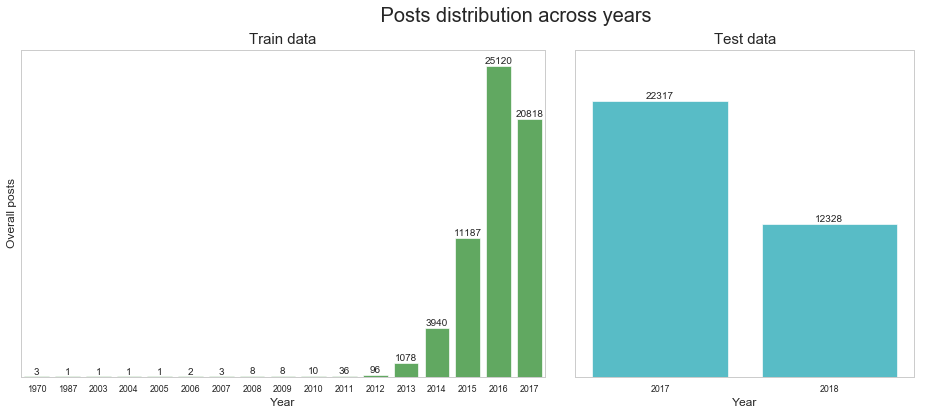

In [5]:
plt.figure(figsize=(16,6))
plt.suptitle("                       Posts distribution across years",fontsize=20)

ax1 = plt.subplot2grid((1,5),(0,0), colspan=3)
ax1 = sns.countplot(x='year', data=train, alpha=0.8, color=color[2])
plt.ylabel('Overall posts', fontsize=12)
plt.xlabel('Year', fontsize=12)
plt.title('Train data', fontsize=15)
plt.grid(False)

for p in ax1.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax1.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')
    
ax2 = plt.subplot2grid((1,5),(0,3), colspan=2, sharey=ax1)
ax2 = sns.countplot(x='year', data=test, alpha=0.8, color=color[9])
plt.xlabel('Year', fontsize=12)
plt.title('Test data', fontsize=15)
plt.yticks([])
plt.ylabel('')

for p in ax2.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax2.annotate('{}'.format(p.get_height()), (x.mean(), y), ha='center', va='bottom')

In [6]:
train['length'].describe()

count     62313.00000
mean       9966.69390
std        8987.28232
min         205.00000
25%        6000.00000
50%        8117.00000
75%       11354.00000
max      423272.00000
Name: length, dtype: float64

In [7]:
print(train.shape)
train = train[train.year >= 2013]
train = train[train['length'] < 150000] 
print(train.shape)

(62313, 13)
(62114, 13)


In [8]:
train_df = train
test_df = test

all_zero_mae = 4.33328

In [9]:
def write_submission_file(prediction,
                          filename,
                          path_to_sample=os.path.join(
                                  PATH,
                                  'sample_submission.csv')):
    submission = pd.read_csv(path_to_sample, index_col='id')

    submission['log_recommends'] = prediction
    submission.to_csv(filename)

In [10]:
# Special transformer to save output shape
class ShapeSaver(BaseEstimator, TransformerMixin):
    def transform(self, X):
        self.shape = X.shape
        return X

    def fit(self, X, y=None, **fit_params):
        return self

In [11]:
# Run preprocessing on full data
x_train_new = train_df.iloc[:, :-1]
x_test_new = test_df.iloc[:, :].copy()
experiments = {}

with open('medium_experiments.pickle', 'rb') as f:
    experiments = pickle.load(f)

In [12]:
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [13]:
def extract_content_as_string(X):
    return X['content']


def extract_content_length(X):
    return pd.DataFrame(X['content'].str.len())


def extract_author_as_string(X):
    return X['author']


def extract_tags_as_string(X):
    return X['tags']


def extract_title_as_string(X):
    return X['title']

def extract_domain_as_string(X):
    return X['domain']


def feature_weekday(X):
    return X[['week_day']]


def feature_hour(X):
    return X[['hour']]


def feature_month(X):
    return X[['month']]


# yearfeature from A4
def feature_year(X):
    return X[['year']]


def feature_len(X):
    return pd.DataFrame(np.log1p(X['length']))
    
    
# Month Q
def feature_month_q1(X):
    return pd.DataFrame(X['published'].dt.month.isin([1, 2, 3]))


# Month Q
def feature_month_q2(X):
    return pd.DataFrame(X['published'].dt.month.isin([4, 5, 6]))


# Month Q
def feature_month_q3(X):
    return pd.DataFrame(X['published'].dt.month.isin([7, 8, 9]))


# Month Q
def feature_month_q4(X):
    return pd.DataFrame(X['published'].dt.month.isin([10, 11, 12]))


# kmeans = KMeans(n_clusters=10, random_state=17).fit(X_train_new)
def kmeans_class(X):
    pd.DataFrame(kmeans.predict(X))
    
    
def stem_tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems


class StemmedCountVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedCountVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])


class TfidfLeammatizerVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(TfidfLeammatizerVectorizer, self).build_analyzer()
        return lambda doc: ([wordnet_lemmatizer.lemmatize(w) for w in analyzer(doc)])

In [14]:
class FittedTransformer(BaseEstimator, TransformerMixin):
    """
    """
    def __init__(self, fitted_transformer):
        self.fitted_transformer = fitted_transformer

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return self.fitted_transformer.transform(X)
    
class ContentVectorizer(TransformerMixin):
    def __init__(self, column = 'content'):
        self.column = column
        self.cv = TfidfLeammatizerVectorizer(
            ngram_range=(1,3),
            max_features=50000,
            strip_accents='unicode',
#             min_df=5,
            sublinear_tf=True
            )
        
    def transform(self, X, **transform_params):
        return self.cv.transform(X[self.column], transform_params)
    
    def fit(self, X, **fit_params):
        return self.cv.fit(X[self.column], fit_params)


In [15]:
content_lemma_tfidf_vectorizer = ContentVectorizer('content') 

In [16]:
content_transofmer = FittedTransformer(content_lemma_tfidf_vectorizer)
content_lemma_tfidf = Pipeline([
    ('count', content_transofmer),
    ('shape', ShapeSaver())
    ])

content_svd = Pipeline([
    ('content_svd_tfidf', FittedTransformer(content_lemma_tfidf)),
    ('tsvd1', decomposition.TruncatedSVD(
        n_components=2000,
        n_iter=25,
        random_state=17)),
#     ("tfidf", TfidfTransformer()),
    ('shape', ShapeSaver())
    ])

author_tfidf =  Pipeline([
    ('extract', FunctionTransformer(extract_author_as_string, validate=False)),
    ('count', TfidfVectorizer(ngram_range=(2, 2), max_features=10000)),
    ('shape', ShapeSaver())
    ])

domain_tfidf = Pipeline([
    ('extract', FunctionTransformer(extract_domain_as_string, validate=False)),
    ('count', TfidfVectorizer(max_features=5000)),
    ('shape', ShapeSaver())
    ])

weekday_cat = Pipeline([
    ('extract', FunctionTransformer(feature_weekday, validate=False)),
    ('ohe', OneHotEncoder()),
    ('shape', ShapeSaver())
    ])

month_cat = Pipeline([
    ('extract', FunctionTransformer(feature_month, validate=False)),
    ('ohe', OneHotEncoder()),
#     ('scale', StandardScaler()),
    ('shape', ShapeSaver())
    ])
    
hour_val = Pipeline([
    ('extract', FunctionTransformer(feature_hour, validate=False)),
    ('scale', StandardScaler()),
#     ('ohe', OneHotEncoder()),
    ('shape', ShapeSaver())
    ])

# len_log = Pipeline([
#     ('extract', FunctionTransformer(feature_len, validate=False)),
#     ('scale', StandardScaler()),
# #     ('ohe', OneHotEncoder()),
#     ('shape', ShapeSaver())
#     ])

mon_q1 = Pipeline([
    ('extract', FunctionTransformer(feature_month_q1, validate=False)),
    ('shape', ShapeSaver())
    ])

mon_q2 = Pipeline([
    ('extract', FunctionTransformer(feature_month_q2, validate=False)),
    ('shape', ShapeSaver())
    ])

mon_q3 = Pipeline([
    ('extract', FunctionTransformer(feature_month_q3, validate=False)),
    ('shape', ShapeSaver())
    ])

mon_q4 = Pipeline([
    ('extract', FunctionTransformer(feature_month_q4, validate=False)),
    ('shape', ShapeSaver())
    ])

year = Pipeline([
    ('extract', FunctionTransformer(feature_year, validate=False)),
#     ('ohe', OneHotEncoder()),
    ('scale', StandardScaler()),
    ])

tags_tfidf = Pipeline([
    ('extract', FunctionTransformer(extract_tags_as_string, validate=False)),
    ('count', TfidfVectorizer(max_features=5000)),
#     ("tfidf", TfidfTransformer()),
    ('shape', ShapeSaver())
    ])
       
feats = FeatureUnion([('author_tfidf', author_tfidf), 
                      ('domain_tfidf', domain_tfidf),
                      ('weekday_cat', weekday_cat),
                      ('month_cat', month_cat),
                      ('hour_val', hour_val),
#                       ('len_log', len_log),
                      ('mon_q1', mon_q1),
                      ('mon_q2', mon_q2),
                      ('mon_q3', mon_q3),
                      ('mon_q4', mon_q4),
                      ('year', year),
                      ('tags_tfidf', tags_tfidf),
                      ('content_lemma_tfidf', content_lemma_tfidf),
#                       ('content_svd', content_svd),
                     ])

transform_pipeline = Pipeline([('feats', feats)])

In [94]:
# --------------------------------------------------------------------------
def full_fit(clf, Xtrain, ytrain, Xtest):
    clf.fit(Xtrain, src_to_pred(ytrain))
    clf_test_pred = pred_to_src(clf.predict(Xtest))
    return clf, clf_test_pred

# --------------------------------------------------------------------------
def full_lgm_fit(clf, Xtrain, ytrain, Xtest):
    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    bst_lgb = lgb.train(clf.params,
                        lgb_x_train_part
                        )

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def full_lgm_fit_cv(clf, Xtrain, ytrain, Xtest):

    bst_lgb = clf.fit(Xtrain.astype(np.float32), src_to_pred(ytrain))

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xtest.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    return bst_lgb, lgb_pred

# --------------------------------------------------------------------------
def train_lgm(Xtrain, ytrain, Xvalid, yvalid, Xtest):
    experiment_name = 'train_lgm' + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [
            v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    lgb_x_train_part = lgb.Dataset(
            Xtrain.astype(np.float32),
            label=src_to_pred(ytrain))

    lgb_x_valid = lgb.Dataset(
            Xvalid.astype(np.float32),
            label=src_to_pred(yvalid))

    param = {'num_leaves': 31,
             'num_trees': 500,
             'objective': 'mean_absolute_error',
             'metric': 'mae'}

    num_round = 100
    bst_lgb = lgb.train(param,
                        lgb_x_train_part,
                        num_round,
                        valid_sets = [lgb_x_valid],
                        early_stopping_rounds=20)

    lgb_pred = pred_to_src(
            bst_lgb.predict(
                    Xvalid.astype(np.float32),
                    num_iteration = bst_lgb.best_iteration))

    lgb_valid_mae = mean_absolute_error(yvalid, lgb_pred)
    print('LGM valid mae: {}'.format(lgb_valid_mae))

    experiment['clf'] = 'lgm'
    experiment['valid_mae'] = lgb_valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(lgb_valid_mae)

    lgb_test_pred = pred_to_src(bst_lgb.predict(Xtest.astype(np.float32)))

    return bst_lgb, lgb_pred, experiment, lgb_test_pred

# --------------------------------------------------------------------------
def train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf.predict(Xtest))

    return clf, clf_pred, experiment, clf_test_pred

# --------------------------------------------------------------------------
def train_sgd(Xtrain, ytrain, Xvalid, yvalid, Xtest):
#    {'alpha': 1e-06,
#     'loss': 'epsilon_insensitive',
#     'max_iter': 1000,
#     'penalty': 'l2'}
    clf = SGDRegressor(random_state = 17,
                       alpha=1e-06,
                       loss='epsilon_insensitive',
                       max_iter=1000,
                       penalty='l2',
                       verbose=1
                       )

    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_sgd')


# --------------------------------------------------------------------------
def train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest, clf_name,
                 grid_params):
    experiment_name = clf_name + time.strftime("%d_%m_%Y_%H_%M_%S")
    experiment = {}
    experiment['time'] = experiment_name

    print(Xtrain.shape)

    experiment['transformed_train_df_shape'] = Xtrain.shape
    experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

    clf_grid = GridSearchCV(
            estimator=clf,
            param_grid=grid_params,
            n_jobs=-1,
            cv=cv,
            verbose=10)

    clf_grid.fit(Xtrain, src_to_pred(ytrain))
    clf_pred = pred_to_src(clf_grid.predict(Xvalid))

    valid_mae = mean_absolute_error(yvalid, clf_pred)
    print('{} valid mae: {}'.format(clf_name, valid_mae))

    experiment['clf'] = clf_name
    experiment['valid_mae'] = valid_mae
    experiment['np.expm1_valid_mae'] = pred_to_src(valid_mae)

    clf_test_pred = pred_to_src(clf_grid.predict(Xtest))

    return clf_grid, clf_pred, experiment, clf_test_pred


# --------------------------------------------------------------------------
def train_ridge_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest, alpha=1.35):
    clf = Ridge(random_state = 17, alpha=alpha)
    grid_params = {
            'alpha': [1e-10, 1e-2, 1, 1.35, 5],
#            'solver' : ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
            }
    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_ridge',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_lgm_cv(cv, Xtrain, ytrain, Xvalid, yvalid, Xtest):
    clf = lgb.LGBMRegressor(random_state=17)
    grid_params = {
            'learning_rate': [0.01, 0.1, 1],
            'n_estimators': [20, 100],
            'early_stopping_rounds': [20, 30],
            'num_leaves': 31,
            'num_trees': [200, 500],
            'max_depth' : [4],
            'seed': [17],
            'objective': 'mean_absolute_error',
            'metric': 'mae'
            }

    return train_clf_cv(clf, cv, Xtrain, ytrain, Xvalid, yvalid, Xtest,
                        'train_lgm',
                        grid_params=grid_params)

# --------------------------------------------------------------------------
def train_ridge(Xtrain, ytrain, Xvalid, yvalid, Xtest, alpha=1.35):
    clf = Ridge(random_state = 17, alpha=alpha)
    return train_clf(clf, Xtrain, ytrain, Xvalid, yvalid, Xtest, 'train_ridge')

In [18]:
# --------------------------------------------------------------------------
def src_to_pred(x):
     return np.log1p(x)  
#     return (np.exp(-x) - np.exp(x))/2
# np.log(1 + x)/np.log(1/5)  # np.log2(1+x)  # np.log(1 + x)/np.log(3)  # math.log(1 + x, 3)  # np.log2(1 + x)


# --------------------------------------------------------------------------
def pred_to_src(x):
#     return np.log(x + np.sqrt(x**2 + 1))   
    return np.expm1(x)  # np.power(1/5, x) - 1  # np.power(2, x) - 1  # np.power(3, x) - 1  # np.expm1(x)

In [19]:
content_lemma_tfidf_vectorizer.fit(x_train_new)

TfidfLeammatizerVectorizer(analyzer='word', binary=False,
              decode_error='strict', dtype=<class 'numpy.float64'>,
              encoding='utf-8', input='content', lowercase=True,
              max_df=1.0, max_features=50000, min_df=1, ngram_range=(1, 3),
              norm='l2', preprocessor=None, smooth_idf=True,
              stop_words=None, strip_accents='unicode', sublinear_tf=True,
              token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None,
              use_idf=True, vocabulary=None)

In [ ]:
experiment_name = time.strftime("%d_%m_%Y_%H_%M_%S")
experiment = {}
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

transformed_train_df = transform_pipeline.fit_transform(x_train_new)
transformed_test_df = transform_pipeline.transform(x_test_new)

In [96]:
X_train_new = transformed_train_df
y_train_new = train_df['target']
X_test_new = transformed_test_df

print(transformed_train_df.shape, transformed_test_df.shape)

experiment['transformed_train_df_shape'] = transformed_train_df.shape
experiment['transformed_test_df_shape'] = transformed_test_df.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

train_part_size = int(0.7 * y_train_new.shape[0])  # !!!!!!!!!!!!!!!!!!!!!!!
X_train_part = X_train_new[:train_part_size, :]
y_train_part = y_train_new[:train_part_size]
X_valid = X_train_new[train_part_size:, :]
y_valid = y_train_new[train_part_size:]

(62114, 65317) (34645, 65317)


In [97]:
# train ridge
ridge, ridge_pred, ridge_experiment, ridge_test_pred = train_ridge(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
ridge_pred1 = pred_to_src(ridge.predict(X_train_part))

print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

(43479, 65317)
train_ridge valid mae: 1.0567314140256445
Ridge valid mae: 1.0567314140256445


Ridge valid mae: 1.0567314140256445


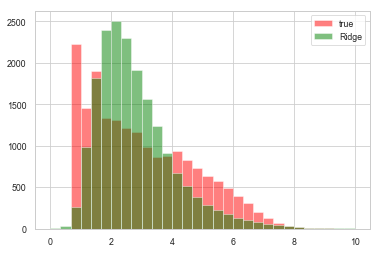

In [98]:
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.legend();

In [99]:
lgm, lgb_pred, lgm_experiment, lgm_test_pred = train_lgm(
        X_train_part,
        y_train_part,
        X_valid,
        y_valid,
        X_test_new)
lgb_pred1 = pred_to_src(lgm.predict(X_train_part))
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))

(43479, 65317)
[1]	valid_0's l1: 0.380501
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.374138
[3]	valid_0's l1: 0.368826
[4]	valid_0's l1: 0.36427
[5]	valid_0's l1: 0.360516
[6]	valid_0's l1: 0.356801
[7]	valid_0's l1: 0.353647
[8]	valid_0's l1: 0.350927
[9]	valid_0's l1: 0.348666
[10]	valid_0's l1: 0.346363
[11]	valid_0's l1: 0.344591
[12]	valid_0's l1: 0.342633
[13]	valid_0's l1: 0.34107
[14]	valid_0's l1: 0.339469
[15]	valid_0's l1: 0.338215
[16]	valid_0's l1: 0.337005
[17]	valid_0's l1: 0.335899
[18]	valid_0's l1: 0.334956
[19]	valid_0's l1: 0.334025
[20]	valid_0's l1: 0.333123
[21]	valid_0's l1: 0.332276
[22]	valid_0's l1: 0.331451
[23]	valid_0's l1: 0.330435
[24]	valid_0's l1: 0.329732
[25]	valid_0's l1: 0.329069
[26]	valid_0's l1: 0.328515
[27]	valid_0's l1: 0.327709
[28]	valid_0's l1: 0.32709
[29]	valid_0's l1: 0.326319
[30]	valid_0's l1: 0.325621
[31]	valid_0's l1: 0.325078
[32]	valid_0's l1: 0.324587
[33]	valid_0's l1: 0.324113
[34]	valid_

[286]	valid_0's l1: 0.308109
[287]	valid_0's l1: 0.308109
[288]	valid_0's l1: 0.308101
[289]	valid_0's l1: 0.308103
[290]	valid_0's l1: 0.308102
[291]	valid_0's l1: 0.308105
[292]	valid_0's l1: 0.308099
[293]	valid_0's l1: 0.308065
[294]	valid_0's l1: 0.308048
[295]	valid_0's l1: 0.308034
[296]	valid_0's l1: 0.308035
[297]	valid_0's l1: 0.30805
[298]	valid_0's l1: 0.30801
[299]	valid_0's l1: 0.307995
[300]	valid_0's l1: 0.30798
[301]	valid_0's l1: 0.307911
[302]	valid_0's l1: 0.307916
[303]	valid_0's l1: 0.307922
[304]	valid_0's l1: 0.307902
[305]	valid_0's l1: 0.307843
[306]	valid_0's l1: 0.307831
[307]	valid_0's l1: 0.307822
[308]	valid_0's l1: 0.307822
[309]	valid_0's l1: 0.307821
[310]	valid_0's l1: 0.307836
[311]	valid_0's l1: 0.307819
[312]	valid_0's l1: 0.307803
[313]	valid_0's l1: 0.307789
[314]	valid_0's l1: 0.307791
[315]	valid_0's l1: 0.307795
[316]	valid_0's l1: 0.3078
[317]	valid_0's l1: 0.307789
[318]	valid_0's l1: 0.307791
[319]	valid_0's l1: 0.307779
[320]	valid_0's l1:

LGM valid mae: 1.135021773207957


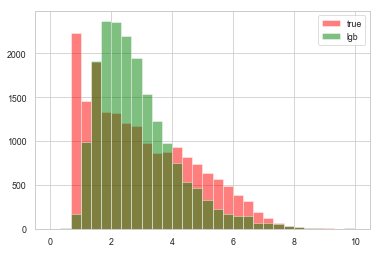

In [100]:
print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(lgb_pred, bins=30, alpha=.5, color='green', label='lgb', range=(0,10));
plt.legend();

LGM valid mae: 1.135021773207957
Ridge valid mae: 1.0567314140256445
Mix valid mae: 1.0683185232634835


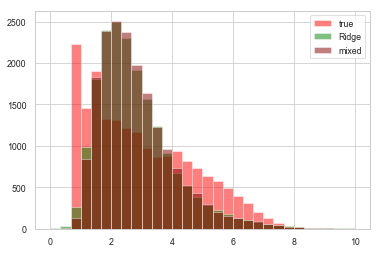

In [101]:
coef_1 = 0.6
coef_2 = 0.4

mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * sgd_pred + coef_2 * ridge_pred
#mix_pred = coef_1 * lgb_pred + coef_2 * ridge_pred
#mix_pred = np.expm1(coef_1 * 1/(lgb_pred**(-2)) + coef_2 * 1/(ridge_pred**(-2)))

print('LGM valid mae: {}'.format(lgm_experiment['valid_mae']))
print('Ridge valid mae: {}'.format(ridge_experiment['valid_mae']))
#print('SGD valid mae: {}'.format(sgd_experiment['valid_mae']))
print('Mix valid mae: {}'.format(mean_absolute_error(y_valid, mix_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
#plt.hist(np.log2(1+y_valid), bins=30, alpha=.5, color='gray', label='true', range=(0,10));
plt.hist(ridge_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

In [108]:
ridge_experiment, lgm_experiment

({'time': 'train_ridge18_11_2018_20_07_11',
  'transformed_train_df_shape': (43479, 65317),
  'features': ['author_tfidf',
   'domain_tfidf',
   'weekday_cat',
   'month_cat',
   'hour_val',
   'mon_q1',
   'mon_q2',
   'mon_q3',
   'mon_q4',
   'year',
   'tags_tfidf',
   'content_lemma_tfidf'],
  'clf': 'train_ridge',
  'valid_mae': 1.0567314140256445,
  'np.expm1_valid_mae': 1.8769520392453511},
 {'time': 'train_lgm18_11_2018_20_08_46',
  'transformed_train_df_shape': (43479, 65317),
  'features': ['author_tfidf',
   'domain_tfidf',
   'weekday_cat',
   'month_cat',
   'hour_val',
   'mon_q1',
   'mon_q2',
   'mon_q3',
   'mon_q4',
   'year',
   'tags_tfidf',
   'content_lemma_tfidf'],
  'clf': 'lgm',
  'valid_mae': 1.1350217732079571,
  'np.expm1_valid_mae': 2.1112412838711339})

In [109]:
experiments[lgm_experiment['time']] = lgm_experiment
experiments[ridge_experiment['time']] = ridge_experiment

with open('medium_experiments.pickle', 'wb') as f:
    pickle.dump(experiments, f)

In [110]:
# ridge, ridge_full_pred = full_fit(ridge, X_train_new, y_train_new, X_test_new)
# lgm, lgm_full_pred = full_lgm_fit(lgm, X_train_new, y_train_new, X_test_new)

# mix_full_pred = coef_1 * lgm_full_pred + coef_2 * ridge_full_pred

# # ==> predict
# full_pred_corrected = \
#     mix_full_pred + (all_zero_mae - mix_full_pred.mean())
# write_submission_file(prediction=full_pred_corrected,
#                       filename=experiment['submission_file'])
# # <== predict

In [111]:
print(lgm_experiment)
print(ridge_experiment)

{'time': 'train_lgm18_11_2018_20_08_46', 'transformed_train_df_shape': (43479, 65317), 'features': ['author_tfidf', 'domain_tfidf', 'weekday_cat', 'month_cat', 'hour_val', 'mon_q1', 'mon_q2', 'mon_q3', 'mon_q4', 'year', 'tags_tfidf', 'content_lemma_tfidf'], 'clf': 'lgm', 'valid_mae': 1.1350217732079571, 'np.expm1_valid_mae': 2.1112412838711339}
{'time': 'train_ridge18_11_2018_20_07_11', 'transformed_train_df_shape': (43479, 65317), 'features': ['author_tfidf', 'domain_tfidf', 'weekday_cat', 'month_cat', 'hour_val', 'mon_q1', 'mon_q2', 'mon_q3', 'mon_q4', 'year', 'tags_tfidf', 'content_lemma_tfidf'], 'clf': 'train_ridge', 'valid_mae': 1.0567314140256445, 'np.expm1_valid_mae': 1.8769520392453511}


In [112]:
transformed_train_df.shape, transformed_test_df.shape

((62114, 65317), (34645, 65317))

In [113]:
NUM_TOPICS = 30

In [114]:
from scipy.sparse import csr_matrix, hstack, vstack

X_train_topics = vstack([X_train_new, X_test_new])
X_train_topics[X_train_topics < 0] = 0

In [107]:
from sklearn.decomposition import NMF

# Build a Non-Negative Matrix Factorization Model
nmf_model = NMF(n_components=NUM_TOPICS)
nmf_Z = nmf_model.fit_transform(X_train_topics)
print(nmf_Z.shape)  # (NO_DOCUMENTS, NO_TOPICS)

(96759, 30)


In [115]:
X_train_nmf = nmf_Z[:X_train_new.shape[0], :]
X_test_nmf = nmf_Z[X_train_new.shape[0]:, :]
X_train_nmf.shape, X_test_nmf.shape

((62114, 30), (34645, 30))

In [116]:
X_train_topics = hstack([X_train_new, X_train_nmf])
X_test_topics = hstack([X_test_new, X_test_nmf])
X_train_topics.shape, X_test_topics.shape

((62114, 65347), (34645, 65347))

In [117]:
X_train_topics.shape, X_test_topics.shape

((62114, 65347), (34645, 65347))

In [118]:
experiment_name = 'nmf_' + time.strftime("%d_%m_%Y_%H_%M_%S")
experiment = {}
experiment['time'] = experiment_name
experiment['submission_file'] = experiment['time'] + '.csv'

In [119]:
experiment['transformed_train_df_shape'] = X_train_nmf.shape
experiment['transformed_test_df_shape'] = X_test_nmf.shape
experiment['features'] = [v[0] for v in transform_pipeline.steps[0][1].transformer_list]

X_train_part_nmf, X_valid_nmf, y_train_part_nmf, y_valid_nmf = \
        train_test_split(
                X_train_topics,
                y_train_new,
                test_size=0.3,
                random_state=17)

In [120]:
# train ridge
ridge_nmf, ridge_nmf_pred, ridge_nmf_experiment, ridge_nmf_test_pred = train_ridge(
        X_train_part_nmf,
        y_train_part_nmf,
        X_valid_nmf,
        y_valid_nmf,
        X_test_topics)

print('Ridge nmf valid mae: {}'.format(ridge_nmf_experiment['valid_mae']))

(43479, 65347)
train_ridge valid mae: 1.0339862064541407
Ridge nmf valid mae: 1.0339862064541407


In [121]:
# ridge_pred1 = pred_to_src(ridge_nmf.predict(X_test_topics))

In [122]:
lgm_nmf, lgb_nmf_pred, lgm_nmf_experiment, lgm_nmf_test_pred = train_lgm(
        X_train_part_nmf,
        y_train_part_nmf,
        X_valid_nmf,
        y_valid_nmf,
        X_test_topics)
lgb_pred1 = pred_to_src(lgm_nmf.predict(X_train_part))
print('LGM nmf valid mae: {}'.format(lgm_nmf_experiment['valid_mae']))

(43479, 65347)
[1]	valid_0's l1: 0.403617
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's l1: 0.395943
[3]	valid_0's l1: 0.389049
[4]	valid_0's l1: 0.382468
[5]	valid_0's l1: 0.377007
[6]	valid_0's l1: 0.37185
[7]	valid_0's l1: 0.367406
[8]	valid_0's l1: 0.363359
[9]	valid_0's l1: 0.359414
[10]	valid_0's l1: 0.356127
[11]	valid_0's l1: 0.353026
[12]	valid_0's l1: 0.350188
[13]	valid_0's l1: 0.347532
[14]	valid_0's l1: 0.345311
[15]	valid_0's l1: 0.343117
[16]	valid_0's l1: 0.341062
[17]	valid_0's l1: 0.339123
[18]	valid_0's l1: 0.33744
[19]	valid_0's l1: 0.335741
[20]	valid_0's l1: 0.334246
[21]	valid_0's l1: 0.333036
[22]	valid_0's l1: 0.331964
[23]	valid_0's l1: 0.330925
[24]	valid_0's l1: 0.329846
[25]	valid_0's l1: 0.329043
[26]	valid_0's l1: 0.328301
[27]	valid_0's l1: 0.327389
[28]	valid_0's l1: 0.326645
[29]	valid_0's l1: 0.325808
[30]	valid_0's l1: 0.324854
[31]	valid_0's l1: 0.324227
[32]	valid_0's l1: 0.323467
[33]	valid_0's l1: 0.322767
[34]	valid

[286]	valid_0's l1: 0.300842
[287]	valid_0's l1: 0.30086
[288]	valid_0's l1: 0.300841
[289]	valid_0's l1: 0.300847
[290]	valid_0's l1: 0.300822
[291]	valid_0's l1: 0.300832
[292]	valid_0's l1: 0.300796
[293]	valid_0's l1: 0.300771
[294]	valid_0's l1: 0.300764
[295]	valid_0's l1: 0.300735
[296]	valid_0's l1: 0.300743
[297]	valid_0's l1: 0.300734
[298]	valid_0's l1: 0.300713
[299]	valid_0's l1: 0.300698
[300]	valid_0's l1: 0.300708
[301]	valid_0's l1: 0.300674
[302]	valid_0's l1: 0.300639
[303]	valid_0's l1: 0.300628
[304]	valid_0's l1: 0.300614
[305]	valid_0's l1: 0.300624
[306]	valid_0's l1: 0.300612
[307]	valid_0's l1: 0.300622
[308]	valid_0's l1: 0.300602
[309]	valid_0's l1: 0.300593
[310]	valid_0's l1: 0.30057
[311]	valid_0's l1: 0.300544
[312]	valid_0's l1: 0.300557
[313]	valid_0's l1: 0.300559
[314]	valid_0's l1: 0.30052
[315]	valid_0's l1: 0.300519
[316]	valid_0's l1: 0.300528
[317]	valid_0's l1: 0.300505
[318]	valid_0's l1: 0.300486
[319]	valid_0's l1: 0.300482
[320]	valid_0's l

LGM nmf valid mae: 1.1356382862616559
Ridge nmf valid mae: 1.0339862064541407
Mix nmf valid mae: 1.051559456218262


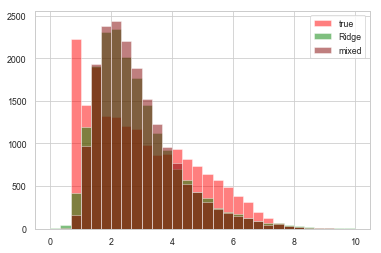

In [127]:
coef_1 = 0.55
coef_2 = 0.45

mix_nmf_pred = coef_1 * lgb_nmf_pred + coef_2 * ridge_nmf_pred

print('LGM nmf valid mae: {}'.format(lgm_nmf_experiment['valid_mae']))
print('Ridge nmf valid mae: {}'.format(ridge_nmf_experiment['valid_mae']))
print('Mix nmf valid mae: {}'.format(mean_absolute_error(y_valid_nmf, mix_nmf_pred)))

plt.hist(y_valid, bins=30, alpha=.5, color='red', label='true', range=(0,10));
plt.hist(ridge_nmf_pred, bins=30, alpha=.5, color='green', label='Ridge', range=(0,10));
plt.hist(mix_nmf_pred, bins=30, alpha=.5, color='maroon', label='mixed', range=(0,10));
plt.legend();

In [124]:
ridge, ridge_full_pred = full_fit(ridge_nmf, X_train_topics, y_train_new, X_test_topics)
lgm, lgm_full_pred = full_lgm_fit(lgm_nmf, X_train_topics, y_train_new, X_test_topics)

mix_full_pred = coef_1 * lgm_full_pred + coef_2 * ridge_full_pred

# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict

In [93]:
# ==> predict
full_pred_corrected = \
    mix_full_pred + (all_zero_mae - mix_full_pred.mean())
write_submission_file(prediction=full_pred_corrected,
                      filename=experiment['submission_file'])
# <== predict

In [ ]:
==> 1.44243